# ATAC peak pileup on hic data


In [1]:
import numpy as np
import pandas as pd
import hicstraw
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from matplotlib import rcParams

## ATAC and hic data

In [4]:

print("\n")
! ls ./ATAC/results/DiffPeakClusters2
print("\n")
! ls ./OCEANC/Neu_H/hic_results/H_hicpro2juicebox | grep -v "rep" | grep ".allValidPairs.hic"



HL60_2d_specific_peaks.bed    NoChangePeak_lowVar.bed
HL60_4d_specific_peaks.bed    NoChangePeak_overlap.bed
HL60_4h_specific_peaks.bed    NoChangePeak_scaled_lowVar.bed
HL60_Ctrl_specific_peaks.bed


HL60_2d.allValidPairs.hic
HL60_4d.allValidPairs.hic
HL60_4h.allValidPairs.hic
HL60_Ctrl.allValidPairs.hic


## take a look at  data

In [5]:

hic_test = hicstraw.HiCFile("./OCEANC/Neu_H/hic_results/H_hicpro2juicebox/HL60_Ctrl.allValidPairs.hic")



In [6]:
print(hic_test.getGenomeID())
print(hic_test.getResolutions())


/HiC-Pro_3.0.0/annotation/chrom_hg19.sizes
[2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000]


#### 

In [7]:
chrom_length = {}
for chrom in hic_test.getChromosomes():
    # print(chrom.name, chrom.length)
    chrom_length[chrom.name] = chrom.length
chrom_length 


{'ALL': 3095693,
 '1': 249250621,
 '2': 243199373,
 '3': 198022430,
 '4': 191154276,
 '5': 180915260,
 '6': 171115067,
 '7': 159138663,
 '8': 146364022,
 '9': 141213431,
 '10': 135534747,
 '11': 135006516,
 '12': 133851895,
 '13': 115169878,
 '14': 107349540,
 '15': 102531392,
 '16': 90354753,
 '17': 81195210,
 '18': 78077248,
 '19': 59128983,
 '20': 63025520,
 '21': 48129895,
 '22': 51304566,
 'X': 155270560,
 'Y': 59373566,
 'M': 16571}

In [8]:
## based on the above output, it maybe different

del chrom_length["ALL"]
del chrom_length["M"]
# del chrom_length[""]
chrom_length 

{'1': 249250621,
 '2': 243199373,
 '3': 198022430,
 '4': 191154276,
 '5': 180915260,
 '6': 171115067,
 '7': 159138663,
 '8': 146364022,
 '9': 141213431,
 '10': 135534747,
 '11': 135006516,
 '12': 133851895,
 '13': 115169878,
 '14': 107349540,
 '15': 102531392,
 '16': 90354753,
 '17': 81195210,
 '18': 78077248,
 '19': 59128983,
 '20': 63025520,
 '21': 48129895,
 '22': 51304566,
 'X': 155270560,
 'Y': 59373566}

## define function to extract rowsum 

In [12]:
chrom_length.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y'])

In [13]:
# extract row sum of Peak bin

def Peak_50bin_aggre_heatmap(Peak, hic, chrom_length, norm, resolution):
    
    ## to speed up. only extract the Matrix from each chromosome once 
    peak_list=[]
    for chromsome in list(chrom_length.keys()):

        # 1. extract the matrix
        matrix_temp = hic.getMatrixZoomData( chromsome, chromsome, "oe", norm, "BP", resolution)

        # 2. extract the Peak in the chromosome
        Peak_temp = Peak[Peak.iloc[:,0] == "chr"+chromsome]
        # print(Peak_temp.shape)
        
        # 3. go over every Peak+/-50binb and locate the bin and extraxt the 1*N matrix. (N is the chromosome length)
        for I in Peak_temp.index:
            Peak_pos = int(Peak_temp.loc[I,1]/resolution)*resolution
                
            if (Peak_pos - 50*resolution )> 0:
                bin1_temp = Peak_pos - 50*resolution
            else:
                bin1_temp = 1
                    
            bin2_temp = Peak_pos  + 50*resolution
            # Segment heatmap matrix   Peak +/-50 BIN
                
            numpy_matrix_temp = matrix_temp.getRecordsAsMatrix(bin1_temp, bin2_temp ,bin1_temp, bin2_temp)

            if (len(numpy_matrix_temp)==101):
                peak_list.append(numpy_matrix_temp)

    print(len(peak_list))
    return  sum(peak_list)/len(peak_list)

## run on the data

In [15]:

ATAC_path = './ATAC/results/DiffPeakClusters2/'

hic_path = './OCEANC/Neu_H/hic_results/H_hicpro2juicebox/'


In [16]:
Conditions = ["Ctrl","4h","2d","4d"]
norm = 'NONE'
resolution = 10**4


In [17]:
N = len(Conditions)
N

4

In [19]:
Conditions[0:4]

['Ctrl', '4h', '2d', '4d']

In [20]:
Peak_dict = {}

for p in Conditions:
    Peak_dict[p] = pd.read_csv(ATAC_path + "HL60_" + p +"_specific_peaks.bed" , header=None, sep='\t')

Peak_dict["NoChange"] = pd.read_csv(ATAC_path + "NoChangePeak_lowVar.bed" , header=None, sep='\t')

In [25]:
[Peak_dict[k].shape for j,k in enumerate(Conditions)]

[(2131, 3), (6494, 3), (2200, 3), (7189, 3)]

## 4h specific peak !

6474
6474
6474
6473


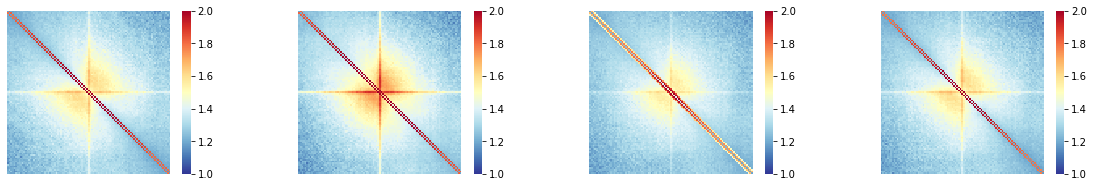

In [24]:

key = "4h"
rcParams['figure.figsize'] = 20,3
fig, axs = plt.subplots(1,4, sharey=True)
for j,k in enumerate(Conditions):
        #  ---> load corresponding hic data
        hic = hicstraw.HiCFile(hic_path + "HL60_" + key  +".allValidPairs.hic")
        #  ---> Peak_50bin_aggre_heatmap
        heatmap = Peak_50bin_aggre_heatmap(Peak_dict[key], hic, chrom_length, norm, resolution)
        
        # ---> draw pileup heatmap based on all hic data
        Max = heatmap.max(axis = 0).max()

        sns.heatmap(heatmap, cmap="RdYlBu_r", vmin=1, vmax=2,xticklabels=False, yticklabels=False,ax=axs[j],square=True)
        

plt.show()
